#TBANLT 570 - Lab Assignment 02 - Document & Term Clustering!
This lab assignment will introduce you to some of the clustering methods that we can use to automatically identify documents and terms (words) that are similar to each other. It is important to understand that these are **unsupervised** methods -- our Python program will learn to identify similar documents and terms on its own without being provided with any guidance about how well it is performing. These techniques can be very useful for identifying latent similarities and differences among a large collection of documents, and for automatically classifying those documents into groups based on how similar they are to each other.

###Learning Objectives
By the time you finish this lab assignment, you will know:
1. How to load data from a comma-separated values (CSV) file into a Pandas dataframe.
2. How to improve our text cleaning algorithm so that it can handle acronyms.
3. How to use scikit-learn's TF-IDF vectorizer to generate TF-IDF vectors and build a vocabulary.
4. How to compute the cosine similarity between two documents.
5. How to draw a dendrogram for document clustering.
6. How to use hierarchical agglomerative clustering to group articles into clusters.
7. How to use divisive K-means clustering to group articles into clusters.
8. How to add pre-trained word embedding vectors to your Python text mining programs.
9. How to compute distances between word embedding vectors.
10. How to identify clusters of similar terms using word embedding vectors.

### Import Libraries
Run the code cell below to import all of the libraries that we'll need for this lab assignment.

In [ ]:
#import libraries
import numpy as np #used to perform numerical operations and work with arrays
import re #regular expressions; used to clean the text data
import pandas as pd #used to manage and work with data
from gensim.models import KeyedVectors #used to work with Google word2vec word embedding vectors
from scipy.cluster import hierarchy #used for drawing dendrograms
from sklearn.cluster import AgglomerativeClustering, KMeans #used to perform agglomerative and divisive clustering
from sklearn.feature_extraction.text import TfidfVectorizer #used to generate TF-IDF vectors and build the vocabulary
from sklearn.metrics.pairwise import cosine_similarity #used to compute cosine similarities between documents

### Load Data
The data for this assignment are a collection of Wikipedia articles. These documents have been provided to you on the course website in the form of a comma-separated values (CSV) file. It is very common for data scientists to work with and share data in CSV format, so it will be useful to learn how to load data from a CSV file into a Pandas dataframe.

Before continuing, be sure to upload the `Lab Assignment 02 - Data.csv` file to your Colab notebook's session storage. After you have uploaded the CSV file, run the code cell below to load all of the articles from the CSV file into a Pandas dataframe.

In [1]:
#load the corpus into a pandas dataframe and preview the first few rows
df = pd.read_csv('Lab Assignment 02 - Data.csv', index_col='id')
df.head()

NameError: ignored

**TASK 01**:
>Write a line of code in the cell below that will display the number of Wikipedia articles in the corpus. *Hint*: Read about the dataframe's `shape` property in [this article](https://pythonexamples.org/pandas-dataframe-shape/).

**QUESTION 01**:
>How many articles are in the corpus?

In [ ]:
#display the number of Wikipedia articles in the corpus


### Clean Raw Text
Next, let's define a function that we can use to clean the raw text of each article. 

Run the code cell below to add the `get_clean_text()` function to your Python program. Note that this is an improved version of the function that we previously used for cleaning text, since this function can handle acronyms. This function also returns the total number of words in the cleaned text, in addition to the cleaned text itself.

In [ ]:
#define a function that will clean the raw input text in preparation for analysis. Returns a tuple containing
#both the cleaned text and the total number of words in the cleaned text.
def get_clean_text(raw_text):
  #find any period-separated acronyms (e.g., 'U.S.A', 'L.A.', etc.)
  period_separated_acronyms = re.findall(r'(?:[A-Z]\.){2,}', raw_text)
  #remove periods from any period-separated acronyms
  for i in range(len(period_separated_acronyms)):
    acronym = period_separated_acronyms[i].replace('.', '')
    raw_text = raw_text.replace(period_separated_acronyms[i], acronym)
  #remove all numbers from the text using a regular expression
  text = re.sub(r'[0-9]', ' ', raw_text)
  #remove all underscores from the text
  text = re.sub(r'\_', ' ', text)
  #remove anything else in the text that isn't a word character or a space (e.g., punctuation, special symbols, etc.)
  text = re.sub(r'[^\w\s]', ' ', text)
  #remove any excess whitespace
  for _ in range(10):
    text = text.replace('  ', ' ')
  #remove any leading or trailing space characters
  text = text.strip()
  #split the text into a list of words
  words = text.split()
  #convert all non-acronyms to lowercase
  for i in range(len(words)): #for each index in the words collection
    word = words[i] #define the current word
    if len(word) > 1 and len(word) < 7: #if this word is two to six characters long
      if word.isupper() == False: #if at least one character in this word is not uppercase
        #this word is not an acronym because it is not all uppercase, so convert it to lowercase
        words[i] = word.lower()
    else: #this word is not an acronym because it consists of one letter or more than six letters, so convert it to lowercase
      words[i] = word.lower()
  #return the cleaned text and the number of words in the cleaned text
  return (' '.join(words), len(words))

Now that the `get_clean_text()` function has been made available to your Python program, you're ready to clean the raw text of each Wikipedia article in the corpus.

Run the code cell below to clean the raw text of each Wikipedia article and save the resulting cleaned text and the total number of words in the article to new columns in the dataframe.

In [ ]:
#clean the raw text of each article and save the resulting cleaned text and total number of words for
#each article in new dataframe columns named 'clean_text' and 'total_words'.
df[['clean_text', 'total_words']] = [get_clean_text(raw_text) for raw_text in df.raw_text]

#show the first few rows in the dataframe
df.head()

In addition to storing the cleaned text for each Wikipedia article in the dataframe, we also stored the number of words in each article. This information can be used to determine how many words are in the entire corpus.

**TASK 02**:
>Write a line of code in the cell below that will display the total number of words in the corpus.

**QUESTION 02**:
>How many total words are in the corpus?

In [ ]:
#display the total number of words in the corpus


An average adult reads 200 to 250 words per minute, so it would take approximately 27 hours to read all of the Wikipedia articles in our corpus.

By contrast, our Python program can "read" all of these articles in just a few seconds!

### Compute TF-IDF Scores & Build the Vocabulary
Since we've already learned how to compute TF-IDF scores manually, we can now save some time by using scikit-learn's `TfidfVectorizer` library to perform this task for us. In addition to computing TF-IDF vectors for each article, this tool can also be used to build the vocabulary of unique words for our corpus.

Run the code cell below to build the vocabulary and compute and add a TF-IDF vector for each article to the dataframe.

In [ ]:
#build the vocabulary of unique words and compute TF-IDF scores for each article
vectorizer = TfidfVectorizer(lowercase=False)
article_tfidf_scores = np.array(vectorizer.fit_transform(df.clean_text).todense())
vocabulary = vectorizer.vocabulary_

#add each article's vector of TF-IDF scores to the dataframe
df['tfidf_scores'] = [tfidf_scores for tfidf_scores in article_tfidf_scores]

**TASK 03**:
>Write a line of code in the cell below that will display the total number of words in the vocabulary.

**QUESTION 03**:
>How many total words are in the vocabulary?

In [ ]:
#display the total number of unique words in the vocabulary


### Cosine Similarity Between Documents
We previously learned how the Euclidean distance between two feature vectors could be used as a measure of similarity between the two corresponding documents from which those vectors were derived. There are, however, many other measures that can be used to judge how similar two documents are to each other. One of the most widely used measures of similarity among text mining practitioners is ***cosine similarity***.

In geometry, a vector is an object that has a magnitude and a direction. If we think of our document vectors in this way, then we can "plot" the documents in our corpus as lines in a geometric space. This concept is illustrated for three documents (*A*, *B*, and *C*) in the figure below:

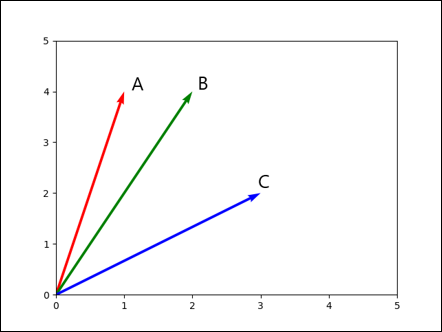

With this notion of documents as geometric vectors in mind, we can now see how the **angle between two document vectors** can be used as a measure of distance between documents. Specifically:
* Smaller angles imply less distance (and hence greater similarity) between documents; and
* Larger angles imply more distance (and hence less similarity) between documents.

In the figure above, Document *A* is much more similar to Document *B* than it is to Document *C*.

If we restrict ourselves to a positive geometric space, then the maximum angle (that is, the maximum distance) between any two vectors is 90 degrees or π/2 radians, while the minimum angle is 0 degrees or 0 radians. The ***cosine similarity*** between two documents, then, is simply the cosine of the angle between the two corresponding document vectors. This is a very convenient measure of similarity because `cos(π/2) = 0` while `cos(0) = 1`. Cosine similary values thus naturally range from 0.0 to 1.0, with a value of 0.0 meaning completely dissimilar and a value of 1.0 meaning completely identical. Neat!

The code cell below shows how to compute the cosine similarity between the TF-IDF vectors for two articles in the corpus.

Run the code cell below to compute the cosine similarity between article 0 and article 108 in the corpus.

In [ ]:
#compute and display the cosine similarity between articles 0 and 108.
article_0 = np.reshape(df.iloc[0]['tfidf_scores'], (1, -1))
article_108 = np.reshape(df.iloc[108]['tfidf_scores'], (1, -1))
similarity = cosine_similarity(article_0, article_108)[0][0]
print('The cosine similarity between articles 0 and 108 is:', similarity)

**TASK 04**:
>Write some code in the cell below that will compute and display the cosine similarity between articles 0 and 156, and between articles 108 and 156.

**QUESTION 04**:
>Which two articles are most similar to each other in terms of cosine similarity? 
* Articles 0 and 108;
* Articles 0 and 156; or
* Articles 108 and 156?

In [ ]:
#compute and display the cosine similarity between articles 0 and 156, and between articles 108 and 156.


Run the code cell below to display the cleaned text for articles 0, 108, and 156. Do you agree with the cosine similarity results?

In [ ]:
#display the cleaned text of articles 0, 108, and 156.
for i in [0, 108, 156]:
  print('article {}: {}'.format(i, df.iloc[i]['clean_text']))

## Document Clustering
We will now turn our attention to document clustering, the goal of which is to automatically identify similarities and dissimilarities among the documents in a corpus, and then classify documents into groups based on how similar they are. These clustering methods are **unsupervised**, meaning that the algorithms assign documents to clusters automatically without us telling them if their choices are correct or not.

There are two major types of clustering algorithms:
1. Agglomerative (bottom-up) methods; and
2. Divisive (top-down) methods.

###Agglomerative Hierarchical Clustering
In this type of clustering, similar objects are gradually grouped into larger and larger clusters, beginning with individual documents and progressing to groups of documents. A useful way of visualizing hierarchical clusters is through the use of a **dendrogram**, which is a type of diagram that depicts a tree structure.

Run the code cell below to generate a dendrogram based on the TF-IDF scores for the articles in the corpus.

In [ ]:
#draw a dendrogram based on the TF-IDF scores
dendrogram = hierarchy.dendrogram(hierarchy.linkage(df.tfidf_scores.to_list(), method='ward'), no_labels=True, color_threshold=0)

The dendrogram suggests that there are likely three major clusters of articles in the corpus. How do we know? Well, a heuristic method of identifying the optimal number of clusters is to find the maximum vertical height of a rectangle that is overlayed across the entire dendrogram, with the constraint that the rectangle cannot "touch" any of the horizontal lines on the dendrogram. This rectangle is shown in light red in the image below. The optimal number of clusters, then, is the number of vertical lines that pass through the rectangle. In this case, three vertical lines pass through the rectangle (numbered *1.*, *2.*, and *3.*), suggesting that the optimal number of clusters is three.

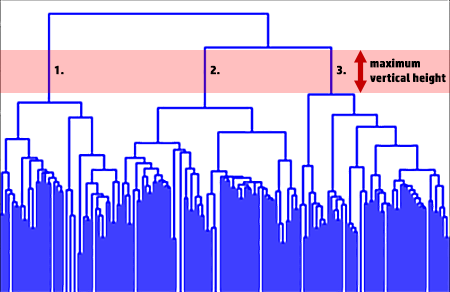

Now that we have an estimate of the optimal number of clusters for the articles in our corpus, we're ready to perform agglomerative clustering and classify each of the articles in the corpus into one of the three possible clusters.

Run the code cell below to use hierarchical agglomerative clustering to group the articles into three clusters and store the resulting cluster assignments in a new column in the dataframe.

In [ ]:
#use hierarchical agglomerative clustering to group the articles into three clusters,
#and add the resulting cluster assignments to the dataframe
model = AgglomerativeClustering(n_clusters=3)
cluster_ids = model.fit_predict(df.tfidf_scores.to_list())
df['agglomerative_cluster_id'] = [cluster_id for cluster_id in cluster_ids]

**TASK 05**:
>Write a line of code that will display the number of articles that were assigned to each cluster by the hierarchical agglomerative clustering algorithm.

**QUESTION 05**:
>How many articles are in the largest cluster according to the hierarchical agglomerative clustering algorithm?

In [ ]:
#display the number of articles that were assigned to each cluster by 
#the hierarchical agglomerative clustering algorithm


###Divisive Clustering
In contrast to agglomerative clustering, ***divisive clustering*** relies on a top-down approach in which the documents are repeatedly partitioned into smaller and smaller clusters.

One very common divisive method is the **k-means clustering algorithm**. This algorithm begins with a random set of cluster centroid positions that are iteratively improved until a stopping criterion is met. Documents are assigned to clusters based on the nearest centroid.

Run the code cell below to use k-means divisive clustering to group the articles into three clusters and store the resulting cluster assignments in a new column in the dataframe.

In [ ]:
#use k-means divisive clustering to group the articles into three clusters,
#and add the resulting cluster assignments to the dataframe
model = KMeans(n_clusters=3, random_state=321)
cluster_ids = model.fit_predict(df.tfidf_scores.to_list())
df['divisive_cluster_id'] = [cluster_id for cluster_id in cluster_ids]

**TASK 06**:
>Write a line of code that will display the number of articles that were assigned to each cluster by the k-means divisive clustering algorithm.

**QUESTION 06**:
>How many articles are in the largest cluster according to the k-means divisive clustering algorithm?

In [ ]:
#display the number of articles that were assigned to each cluster by 
#the K-means divisive clustering algorithm


Run the code cell below to display the first five articles for each cluster, as determined by the agglomerative clustering algorithm. Do you feel that the articles in each cluster are appropriately categorized? Does the content of the articles in each cluster appear to be related?

In [ ]:
#display the first five articles for each cluster, as determined by the agglomerative clustering algorithm
for cluster_id in range(3):
  number_of_articles = 0
  for article in df.itertuples():
    if article.agglomerative_cluster_id == cluster_id:
      print('cluster {}: {}'.format(cluster_id, article.clean_text))
      number_of_articles += 1
      if number_of_articles == 5:
        print('\n')
        break

Keep in mind that we began only with the raw text of each article -- our Python program has categorized these documents entirely on its own!

##Term Clustering Using Word Embeddings
The goal of ***term clustering*** is to find terms that are semantically similar in some way. There are many approaches to finding semantically similar terms, including by using topic language models, pointwise mutual information, and word embedding. Among these, word embedding represents the current state-of-the-art in term clustering, and we will hence focus on word embedding for the remainder of this lab assignment.

###Word Embedding
In ***word embedding***, each word is represented as a vector. Conceptually, this is very similar to representing documents as vectors in that each vector represents the word's location in a multidimensional space. Vector representations for each word are learned using a neural network, and the resulting vector locations have meaning relative to one another. Specifically, vectors of semantically similar words are closer to each other (in terms of cosine distance) than vectors for semantically dissimilar words. Google’s famous word embedding implementation is called **word2vec**, which we will be using in this assignment.

Run the code cell below to download Google's pre-trained word2vec word embedding vectors and load those vectors into a word2vec object. Be patient -- these word embedding vectors were trained on millions of articles from Google News, and the resulting file is about 1.5 gigabytes!

In [ ]:
#download the pre-trained word2vec word embedding vectors and load those vectors into a word2vec object
!wget -c 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

As with document vectors, one of the interesting things that we can do with word embedding vectors is determine the degree of semantic similarity between two words.

**TASK 07**:
>Run the code cell below to get the vector for the word `nachos` and then compute the cosine similarity between that vector and the vectors for several other terms. Note that cosine similarity is equal to `(1 - cosine distance)`.

**QUESTION 07**:
>According to the word2vec vectors, which term is most semantically similar to the word 'nachos'?
* Tortilla chips
* French fries
* Burrito
* Airplane


In [ ]:
#get the vector for the word 'nachos'
vec_nachos = word2vec.get_vector('nachos')

#compute the cosine similarity between 'nachos' and several other words
words = ['tortilla_chips', 'french_fries', 'burrito', 'airplane']
distances = word2vec.distances(vec_nachos, words)
similarities = 1 - distances
similarities

Another very intersting thing that we can do with word embedding vectors is identify terms that are most semantically similar to a set of other terms. This can lead to some very interesting insights.

Run the code cell below to identify the word whose vector is most similar to the average of the vectors for the words `baby` and `cat`. 

In [ ]:
#identify the word whose vector is most similar to the average of the vectors for 'baby' and 'cat'
result = word2vec.most_similar(positive=['baby', 'cat'], topn=1)
result

As you can see, this sort of vector-based term clustering has the potential to yield some fascinating discoveries!

**TASK 08**:
>Write some code in the cell below that will identify the word whose vector is most similar to the average of the vectors for the words 'Canada' and 'Seattle'.

**QUESTION 08**:
>Which word's vector is most similar to the average of the vectors for 'Canada' and 'Seattle'? *Be sure to use proper capitalization for 'Canada' and 'Seattle'!*

In [ ]:
#identify the word whose vector is most similar to the average of the vectors for 'Canada' and 'Seattle'


Very interesting!

Finally, let's see how we can use the collective knowledge embedded in word vectors to infer information about a topic of interest. In this case, let's see what we can learn about the traits of the world's most popular pets -- cats and dogs.

**TASK 09**:
>Run the code cell below to compute the cosine similarities between a set of traits and each type of pet.

**QUESTION 09**:
>What do the cosine similarity values suggest about the differences between cats and dogs?

Do you agree with the results?

In [ ]:
#get the vector for the words 'cat' and 'dog'
vec_cat = word2vec.get_vector('cat')
vec_dog = word2vec.get_vector('dog')

#get vectors for several adjectives
vectors = []
adjectives = ['soft', 'friendly', 'clever', 'loving', 'small', 'loud']
for adjective in adjectives:
  vectors.append(word2vec.get_vector(adjective))

#print the list of adjectives to allow for easy comparisons
print('      soft       friendly   clever     loving     small      loud')

#compute the cosine similarities between the adjectives and each type of pet
similarities = word2vec.cosine_similarities(vec_cat, vectors)
print('cat:', similarities)
similarities = word2vec.cosine_similarities(vec_dog, vectors)
print('dog:', similarities)

## End of Lab Assignment 02!